## TOP 50 LIVROS MAIS VENDIDOS NA AMAZON

Esse projeto consiste em análise exploratória de dataset contendo a lista dos 50 livros mais vendidos da Amazon no período de 2009 a 2019.

Colunas do dataset e suas características:
<ol>
    <li>Name: título do livro</li>
    <li>Author: nome do autor da obra</li>
    <li>User rating: nota atribuída ao livro por usuários da Amazon</li>
    <li>Reviews: número de avaliações do tipo resenha (texto) deixada pelos usuários da Amazon</li>
    <li>Price: preço dos livros em dólar americano</li>
    <li>Year: o ano em que o livro entrou no ranking de mais vendido</li>
    <li>Genre: os livros são classificados genericamente como obras de ficção ou de não ficção</li>
</ol>

A primeira etapa exploratória busca responder as seguintes perguntas:
<ol>
    <li>Que autores de livros receberam as maiores notas de avaliação?</li>
    <li>Que autor escreveu a maiora dos libros mais vendidos?</li>
    <li>Que livro tem mais avaliações escritas?</li>
    <li>Os gêneros se diferenciam quando recebem notas?</li>
</ol>

#### Importando bibliotecas

In [61]:
import pandas as pd
import numpy as np
import missingno
import fuzzywuzzy
from fuzzywuzzy import process
import collections
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

/Users/irenacostaibm/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



#### Descriçao e limpeza dos dados
##### Nesse bloco será feito análise exploratória dos tipos de dados, valores nulos, dados duplicados, relação entre as variáveis, etc

<li>Tipos de dados</li>

In [62]:
maisvendidos = pd.read_csv('../AmazonBooks/input/bestsellers with categories.csv')
maisvendidos.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [64]:
print(f'O dataset contem {maisvendidos.shape[0]} registros e {maisvendidos.shape[1]} colunas.')

O dataset contem 550 registros e 7 colunas.


In [65]:
maisvendidos.dtypes

Name            object
Author          object
User Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object

 dataset contem 3 colunas categoricas e 4 colunas contendo valores numéricos. Para continuar a análise, foi efetuada a conversão da coluna Genre para o tipo 'category' e deixando a coluna Year como numero.


In [66]:
maisvendidos.Genre = maisvendidos.Genre.astype('category')

##### Valores nulos (missing values)

Cálculo da porcentagem de colunas preenchidas e em branco. Primeiro por meio de loop pelas colunas para checar os valores em branco (missing values).

In [67]:
for col in maisvendidos.columns:
    pct_missing = maisvendidos[col].isnull().mean()
    print(f'{col} - {pct_missing : 1%}')

Name -  0.000000%
Author -  0.000000%
User Rating -  0.000000%
Reviews -  0.000000%
Price -  0.000000%
Year -  0.000000%
Genre -  0.000000%


#### **Visualizando os valores em branco.**

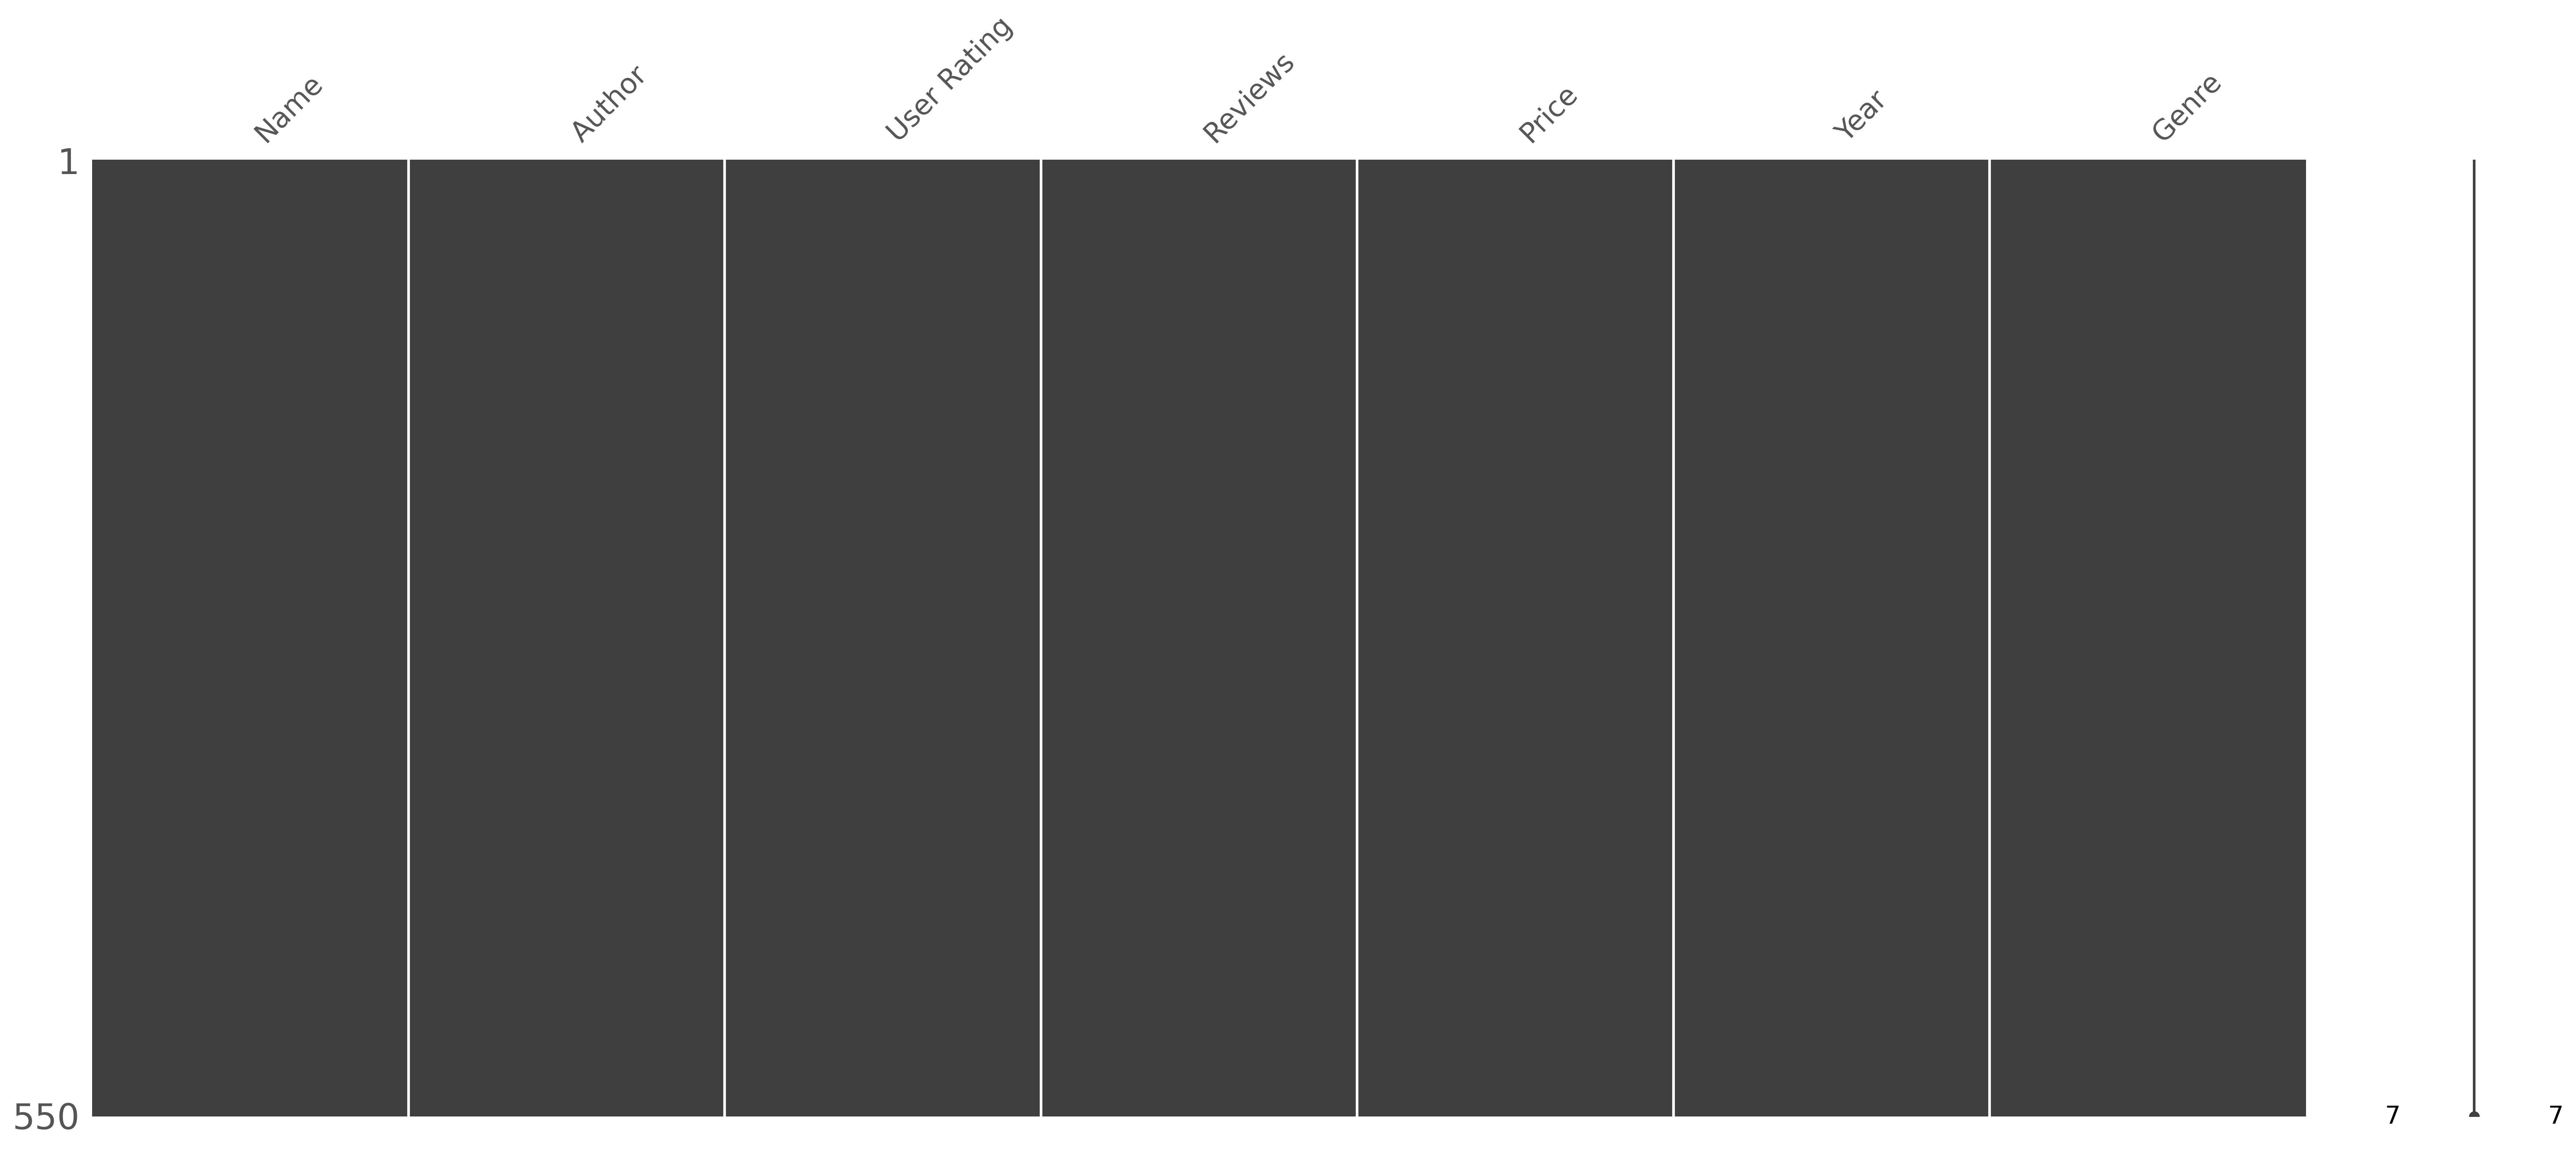

In [68]:
missingno.matrix(maisvendidos, fontsize = 16)
plt.show()

**Conclusão**: o dataset não possui valores em branco, portanto nenhuma transformação se faz necessária.

#### **Checando se as colunas possuem valores duplicados**

In [69]:
col_name_without_numeric_data = list(maisvendidos.select_dtypes(exclude=('int', 'float')).columns)
print(f'Colunas sem dados numericos: {", ".join(col_name_without_numeric_data)}.')

Colunas sem dados numericos: Name, Author, Genre.


In [70]:
for col in col_name_without_numeric_data:
    if maisvendidos[col].duplicated().any() == True:
        print (f'A coluna {col} contem valores duplicados.')
    else:
        print(f'A coluna {col} não possui valores duplicados.')

A coluna Name contem valores duplicados.
A coluna Author contem valores duplicados.
A coluna Genre contem valores duplicados.


<h4> Checando se as colunas possuem palavras com variações irregulares de maiúsculas e minúsculas, e espaços extras </h4>

In [75]:
for col in col_name_without_numeric_data:
    print(f'Antes de {col}: {len(set(maisvendidos[col]))} Depois de {col}:{len(set(maisvendidos[col].str.title().str.strip()))}')

Antes de Name: 351 Depois de Name:350
Antes de Author: 248 Depois de Author:248
Antes de Genre: 2 Depois de Genre:2


##### **Correção dos erros de digitação na coluna Name**

In [76]:
maisvendidos.Name = maisvendidos.Name.str.title().str.strip()

<p><b>Checando se as correções na coluna Name foram efetuadas</b></p>

In [78]:
for col in col_name_without_numeric_data:
    print(f'Antes de { col}: {len(set(maisvendidos[col]))} Depois de {col}: {len(set(maisvendidos[col].str.title().str.strip()))}')

Antes de Name: 350 Depois de Name: 350
Antes de Author: 248 Depois de Author: 248
Antes de Genre: 2 Depois de Genre: 2


<p><b>Checando se há nomes de autores repetidos escritos de maneira diferentes </b></p>

In [79]:
autores = maisvendidos.Author.sort_values().unique()
autores

array(['Abraham Verghese', 'Adam Gasiewski', 'Adam Mansbach', 'Adir Levy',
       'Admiral William H. McRaven', 'Adult Coloring Book Designs',
       'Alan Moore', 'Alex Michaelides', 'Alice Schertle', 'Allie Brosh',
       'American Psychiatric Association',
       'American Psychological Association', 'Amor Towles', 'Amy Ramos',
       'Amy Shields', 'Andy Weir', 'Angie Grace', 'Angie Thomas',
       'Ann Voskamp', 'Ann Whitford Paul', 'Anthony Bourdain',
       'Anthony Doerr', 'Atul Gawande', 'Audrey Niffenegger',
       'B. J. Novak', 'Bessel van der Kolk M.D.', 'Bill Martin Jr.',
       "Bill O'Reilly", 'Bill Simmons', 'Blue Star Coloring',
       'Bob Woodward', 'Brandon Stanton', 'Brené Brown',
       'Brian Kilmeade', 'Bruce Springsteen', 'Carol S. Dweck',
       'Celeste Ng', 'Charlaine Harris', 'Charles Duhigg',
       'Charles Krauthammer', 'Cheryl Strayed', 'Chip Gaines',
       'Chip Heath', 'Chris Cleave', 'Chris Kyle', 'Chrissy Teigen',
       'Christina Baker Kline', 

<p>Os autores George R. R. Martin e J. K. Rowling estão com seus nomes escritos de maneiras diferentes. Para corrigir isso, será utilizada a biblioteca fuzzywuzzy.</p>

In [81]:
autores_nome = fuzzywuzzy.process.extract('George R.R. Martin', autores, limit=5, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
autores_nome

[('George R. R. Martin', 100),
 ('George R.R. Martin', 100),
 ('George Orwell', 53),
 ('Bill Martin Jr.', 52),
 ('Mark R. Levin', 48)]

In [82]:
autores_nome = fuzzywuzzy.process.extract('J.K. Rowling', autores, limit=5, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
autores_nome

[('J. K. Rowling', 100),
 ('J.K. Rowling', 100),
 ('Mark Owen', 50),
 ('Mark Twain', 48),
 ('William P. Young', 46)]

In [85]:
maisvendidos = maisvendidos.replace('George R. R. Martin', 'George R.R. Martin')
maisvendidos = maisvendidos.replace('J. K. Rowling', 'J.K. Rowling')

In [86]:
for col in col_name_without_numeric_data:
    print(f'Antes de {col}: {len(set(maisvendidos[col]))} Depois de {col}: {len(set(maisvendidos[col].str.title().str.strip()))}')

Antes de Name: 350 Depois de Name: 350
Antes de Author: 246 Depois de Author: 246
Antes de Genre: 2 Depois de Genre: 2


Checando a coluna Genre (gênero dos livros) verificou-se que tudo está certo com essa coluna:

In [87]:
genero_livro = maisvendidos.Genre.unique()
genero_livro

['Non Fiction', 'Fiction']
Categories (2, object): ['Fiction', 'Non Fiction']

Checando a coluna de anos verificou-se que está tudo certo com os atributos dessa coluna:

In [88]:
ano_livro = list(maisvendidos.Year.unique())
ano_livro

[2016, 2011, 2018, 2017, 2019, 2014, 2010, 2009, 2015, 2013, 2012]

Observando a coluna de títulos dos livros, verificou-se que há duplicidade de registros de alguns títulos. Para confirmar, foram buscadas as 5 últimas linhas do dataframe.


In [89]:
maisvendidos.tail()

,Name,Author,User Rating,Reviews,Price,Year,Genre
545,Wrecking Ball (Diary Of A Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction
549,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2019,Non Fiction


É importante notar que a duplicidade dos títulos nos dados, ams com anos diferentes. Para alinhar melhor a análise, besse bloco, optou-se por remover as duplicidades tirando os anos nesse momento para que sejam usados em uma análise posterior.

In [90]:
del maisvendidos['Year']

In [91]:
maisvendidos = maisvendidos.drop_duplicates(keep='first')
maisvendidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 546
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         361 non-null    object  
 1   Author       361 non-null    object  
 2   User Rating  361 non-null    float64 
 3   Reviews      361 non-null    int64   
 4   Price        361 non-null    int64   
 5   Genre        361 non-null    category
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 17.4+ KB


Foram retornados 11 livros a mais do que realmente tem. Vamos analisar porque a duplicidade ocorre contando o número de vezes que cada livro aparece no dataframe.

In [92]:
conta_livros = collections.Counter(maisvendidos.Name.tolist())
print(conta_livros.most_common(11))

[('The Help', 3), ('Gone Girl', 2), ("Quiet: The Power Of Introverts In A World That Can'T Stop Talking", 2), ('The 5 Love Languages: The Secret To Love That Lasts', 2), ('The 7 Habits Of Highly Effective People: Powerful Lessons In Personal Change', 2), ('The Fault In Our Stars', 2), ('The Girl On The Train', 2), ('The Immortal Life Of Henrietta Lacks', 2), ('To Kill A Mockingbird', 2), ('Unbroken: A World War Ii Story Of Survival, Resilience, And Redemption', 2), ('10-Day Green Smoothie Cleanse', 1)]


Puxando o livro "The Help"

In [93]:
maisvendidos[maisvendidos['Name'] == 'The Help']

,Name,Author,User Rating,Reviews,Price,Genre
402,The Help,Kathryn Stockett,4.8,13871,6,Fiction
404,The Help,Kathryn Stockett,4.8,13871,8,Fiction
405,The Help,Kathryn Stockett,4.8,13871,7,Fiction


Observa-se que há duplicidade em consequência do preço do livro. Em diferentes anos, o mesmo livro apresenta preços diferentes, o que é lógico levando em consideraçao questões econômicas como inflação, demanda, etc.   


<b>Dropando as duplicidades</b>

In [94]:
maisvendidos = maisvendidos.drop_duplicates(subset='Name', keep='last')
maisvendidos

,Name,Author,User Rating,Reviews,Price,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,Fiction
2,12 Rules For Life: An Antidote To Chaos,Jordan B. Peterson,4.7,18979,15,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,Non Fiction
...,...,...,...,...,...,...
538,Winter Of The World: Book Two Of The Century T...,Ken Follett,4.5,10760,15,Fiction
539,Women Food And God: An Unexpected Path To Almo...,Geneen Roth,4.2,1302,11,Non Fiction
540,Wonder,R. J. Palacio,4.8,21625,9,Fiction
545,Wrecking Ball (Diary Of A Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,Fiction


<b>Conclusão:</b> o dataframe agora apresenta 350 livros diferentes escritos por 246 autores. Todos os livros foram apresentados em duas categorias(Não ficçao, Ficção).

#### <b>Dados categóricos</b>

Nessa seçãp, serão analizados os dados categóricospara responder quatro perguntas:
<ol>
    <li>Que autores de livros receberam as maiores médias de notas?</li>
    <li>Que autor escrveu a maioria dos livros mais vendidos?</li>
    <li>Que gêneros se tornaram mais vendidos com frequência?</li>
    <li>Que livro possui mais avaliações?</li>
</ol>

Foi criado um novo dataframe baseado na média de notas dos autores, número de livros escritos por autores, números de avaliações por livros ou o número de livros por gênero. 

<i>Pegando todos os autores com maiores médias de notas, os autores que escreveram a maioria dos mais vendidos, os livros com o número de avaliações, número de livros por gênero</i>

In [98]:
top_13_autores = maisvendidos.groupby('Author')[['User Rating']].mean() \
                                                                .sort_values('User Rating', ascending=False) \
                                                                .head(13) \
                                                                .reset_index()

numero_livros_escritos = maisvendidos.groupby('Author')[['Name']].count() \
                                                                .sort_values('Name', ascending=False) \
                                                                .head(10) \
                                                                .reset_index()

livros_com_reviews = maisvendidos.groupby('Name')[['Reviews']].sum() \
                                                                .sort_values('Reviews', ascending=False)\
                                                                .head(5)\
                                                                .reset_index()

numero_livros_genero = maisvendidos.groupby('Genre')[['Name']].count()\
                                                                .sort_values('Name', ascending=False)\
                                                                .head(10)\
                                                                .reset_index()

<b>Visualizando os parâmetros dos melhores autores por notas dadas por usuários da Amazon:</b>

In [101]:
fig1 = make_subplots(rows=1, cols=1, subplot_titles=(""))

fig1.add_trace(go.Table(columnorder = [1,2],
                        columnwidth = [100,50],
                        header = dict(values=top_13_autores.columns,
                                    line_color='darkslategray',
                                    height=30),
                        cells=dict(values=[top_13_autores['Author'],
                        top_13_autores['User Rating']],
                        line_color='darkslategray',
                        fill_color='White')))

fig1.update_layout(showlegend=False,
                    title_text='Top 13 autores por nota',
                    title_font_size=16,
                    title_font_family='Arial',
                    title_x=0.5,
                    font=dict(family='Arial',
                                size=12,
                                color='black'))

fig1.show()

### Importando bibliotecas e configurando ambiente 

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/amazonbooks/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

##### Configurando o processamento de dados, ferramentas básicas de visualização e visualizações especiais:

In [6]:
#Biblioteca de Processamento de dados
from tracemalloc import Snapshot
import numpy as np
import pandas as pd

#Ferramentas básicas de visualização de dados
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_palette('husl')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

#Visualizações especiais
import wordcloud, missingno
from wordcloud import WordCloud
import missingno as msno #verifica valores em branco (missing values)
import networkx as nx

## Plotly visualization ##
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected=True) #Necessário para uso do plotly no módulo offiline no Jupyter Notebook

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Mostra comentário formatado na saída da platagem usando negrito, itálico, etc... 
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))


### OS 50 LIVROS MAIS VENDIDOS

#### Leitura e rápida análise dos dados:

In [7]:
dados = pd.read_csv('../AmazonBooks/input/bestsellers with categories.csv')
dados.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [9]:
dados.describe() #numérica

,User Rating,Reviews,Price,Year
count,550.000000,550.000000,550.000000,550.000000
mean,4.618364,11953.281818,13.100000,2014.000000
std,0.226980,11731.132017,10.842262,3.165156
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4058.000000,7.000000,2011.000000
50%,4.700000,8580.000000,11.000000,2014.000000
75%,4.800000,17253.250000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


In [11]:
dados.describe(include='O') #categórica

,Name,Author,Genre
count,550,550,550
unique,351,248,2
top,Publication Manual of the American Psychologic...,Jeff Kinney,Non Fiction
freq,10,12,310


##### Checando dados inexistentes com a biblioteca "missingno":

<AxesSubplot:>

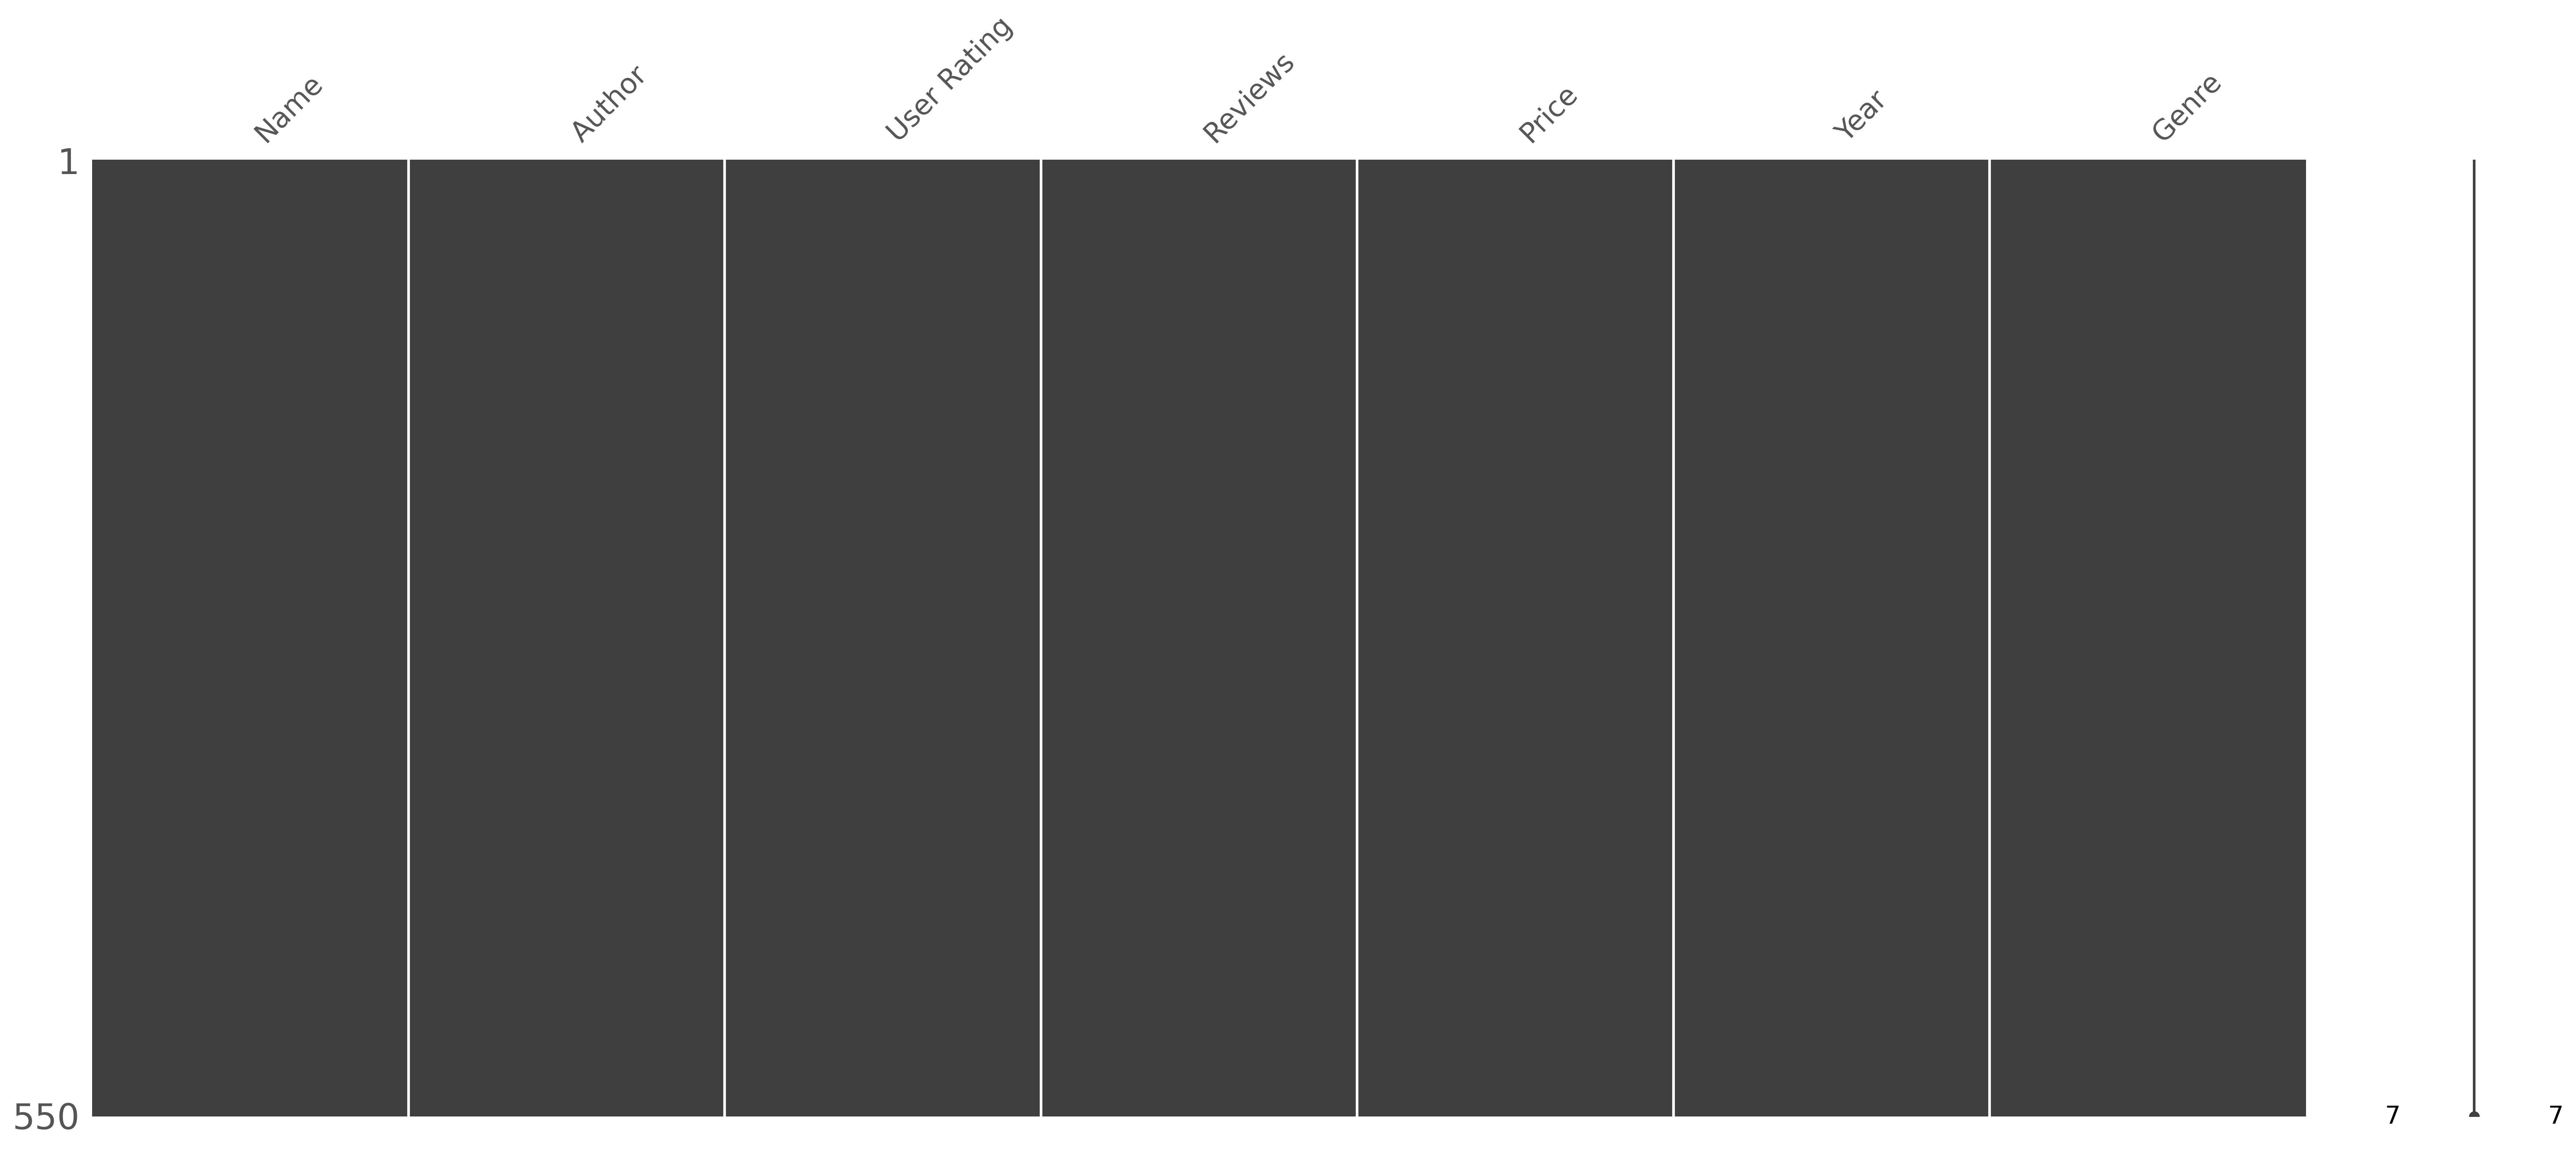

In [12]:
msno.matrix(dados)

<ul><li>Verificou-se com essa análise que o dataset não possui dados nulos/vazios/inexistentes.</li></ul>

#### CONTAGEM DE PONTUAÇÕES DOS MAIS VENDIDOS

In [33]:
temp_df = dados['User Rating'].value_counts().reset_index()

trace1 = go.Bar(
                x = temp_df['index'],
                y = temp_df['User Rating'],
                marker = dict(color = 'rgb(255,165,0)',
                                line=dict(color='rgb(0,0,0)',width=15)))
                               
layout = go.Layout(template= "plotly_dark",title = 'RATINGS COUNT' , 
xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

def pie_plot(cnt_srs, title):
    labels=cnt_srs.index
    values=cnt_srs.values
    trace = go.Pie(labels=labels,
                    values=values,
                    title=title,
                    hoverinfo='percent+value',
                    textinfo='percent',
                    textposition='inside',
                    hole=0.7,
                    showlegend=True,
                    marker=dict(colors=plt.cm.viridis_r(np.linspace(0,1,14)),
                                line=dict(color='#000000', width=2),
                                )
                    )
    
    return trace
bold("**A MAIORIA DAS OBRAS RECEBEU PONTUAÇOES QUE VÃO DE 4.6 A 4.8**")
py.iplot([pie_plot(dados['User Rating'].value_counts(), 'Rating')])

**A MAIORIA DAS OBRAS RECEBEU PONTUAÇOES QUE VÃO DE 4.6 A 4.8**

#### RELAÇÃO ENTRE PREÇO E PONTUÇÃO DE OBRAS PELOS USUÁRIOS

<p>Foi utilizado regplot como uma plotagem simples para essa análise</p>    

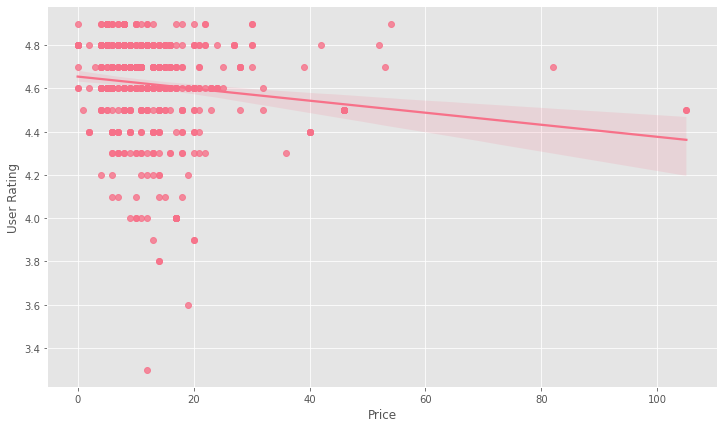

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), dpi=72)
sns.regplot(data=dados, x='Price', y='User Rating', ax=ax)
plt.show()

<ul>
<li>As pontuações dados pelos usuários mostram uma tendência de leve correlaçao negativa com o preço do livro que faz parte da lista de mais vendidos.</li>
<li>A maioria dos livros apresenta preço inferior a US$ 50,00, portanto não se pode chegar a uma conclusão definitiva acerca dessa relação.</li>
</ul>

#### RELAÇÃO ENTRE PREÇO E AVALIAÇÃO DAS OBRAS FEITAS PELOS USUÁRIOS

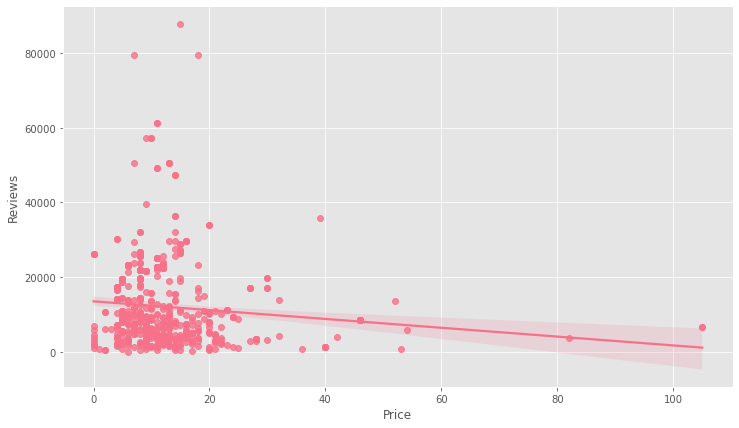

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), dpi=72)
sns.regplot(data=dados, x='Price', y='Reviews', ax=ax)
plt.show()

 <p>As avaliações e o Preço tendem a mostrar quase uma correlação similar ao das Pontuações dos Usuários e o Preço. Mais uma vez, a maioria das obras mais vendidas está agrupada em preços na faixa de preços inferior a US$ 50, nao se podendo chegar a uma conclusão mais clara sobre essa relação.</p>   

#### OS MAIS VENDIDOS DE FICÇÃO E NÃO FICÇÃO

In [36]:
temp_df = dados['Genre'].value_counts().reset_index()


trace1 = go.Bar(
                x = temp_df['index'],
                y = temp_df['Genre'],
                marker = dict(color= 'rgb(255,165,0)',
                              line=dict(color='rgb(0,0,0)',width=15)))
layout = go.Layout(template= "plotly_dark", xaxis = dict(title = 'Genre'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

##### Função para fazer plotagem do tipo Pie usando Plotly

In [37]:
def pie_plot(cnt_srs, colors, title):
    labels=cnt_srs.index
    values=cnt_srs.values
    trace = go.Pie(labels=labels,
                    values=values,
                    title=title,
                    hoverinfo='percent+value',
                    textinfo='percent',
                    textposition='inside',
                    hole=0.7,
                    showlegend=True,
                    marker=dict(colors=colors,
                               line=dict(color='#000000', width=2),
                                )
                    )
    return trace

bold("**OBRAS DE NÃO FICÇÃO SÁO MAIS VENDIDAS QUE OBRAS DE FICÇÃO**")
py.iplot([pie_plot(dados['Genre'].value_counts(), ['magenta', 'cyan'], 'GENRE')])

**OBRAS DE NÃO FICÇÃO SÁO MAIS VENDIDAS QUE OBRAS DE FICÇÃO**

Análise: a contagem dos livros mais vendidos apresenta-se como constante no período analisado (2009-2019). A distribuição do gênero dessas obras pode ser vista nas plotagens acima.

In [59]:

temp_df1 = dados['Year'].value_counts().reset_index()


# create trace1
trace1 = go.Bar(
                x = temp_df1['index'],
                y = temp_df1['Year'],
                marker = dict(color = 'rgb(255,165,0)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(template= "plotly_dark",title = 'OS LIVROS MAIS VENDIDOS NO PERÍODO DE 2009 A 2019' , xaxis = dict(title = 'Ano'), yaxis = dict(title = 'Contagem'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()
d1 = dados[dados["Genre"] == "Fiction"]
d2 = dados[dados["Genre"] == "Non Fiction"]

col ="Year"

vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns = {col : "count", "index" : col})
vc1['percent'] = vc1['count'].apply(lambda x : 100*x/sum(vc1['count']))
vc1 = vc1.sort_values(col)

vc2 = d2[col].value_counts().reset_index()
vc2 = vc2.rename(columns = {col : "count", "index" : col})
vc2['percent'] = vc2['count'].apply(lambda x : 100*x/sum(vc2['count']))
vc2 = vc2.sort_values(col)

In [60]:
trace1 = go.Scatter(
                    x=vc1[col], 
                    y=vc1["count"], 
                    name="Fiction", 
                    marker=dict(color = 'rgb(249, 6, 6)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))

trace2 = go.Scatter(
                    x=vc2[col], 
                    y=vc2["count"], 
                    name="Non Fiction", 
                    marker= dict(color = 'rgb(26, 118, 255)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(hovermode= 'closest', title = 'GÊNERO DOS LIVROS MAIS VENDIDOS AO LONGO DOS ANOS (2009-2019)' , xaxis = dict(title = 'Ano'), yaxis = dict(title = 'Contagem'),template= "plotly_dark")
fig = go.Figure(data = [trace1, trace2], layout=layout)
fig.show()

In [ ]:
df1 = dados[dados["Genre"] == "Fiction"]
df2 = dados[dados["Genre"] == "Non Fiction"]

temp_df1 = df1['User Rating'].value_counts().reset_index()
temp_df2 = df2['User Ratinf'].value_counts().reset_index()